# **BDTs at work: the $\mathrm{D}^{+}_{s}$ analysis**

The goal of this tutorial is to train and test a multi-class classification algorithm. The tutorial focuses on the measurement of the $\mathrm{D}^{+}_{s}$ meson in pp collisions with the data collected by ALICE in the first year of Run 3. 

The $\mathrm{D}^{+}_{s}$ meson is reconstructed in its hadronic decay channel $\mathrm{D}^{+}_{s} \rightarrow \mathrm{\phi} + \pi^+ + K^+ + K^- + \pi^-$. The $\mathrm{D}^{+}_{s}$ mesons are typically categorised as either _prompt_ (i.e. originating from charm quark hadronisation) or _non-prompt_ (i.e. originating from beauty-hadron decay). In this tutorial both these classes are considered. In particular, the ML algorithm is going to classify the $\mathrm{D}^{+}_{s}$ meson candidates as: prompt, non-prompt, or background.

To this end we need to train the ML algorithm with examples from all the three classes. For the signal we will use MC simulations, while for the background we will use the data collected in pp collisions by ALICE in Run 3.
In particular:
- MC production: _LHC22b1b_ (charm-enriched), _LHC22b1a_ (beauty-enriched)
- Data: _LHC22o_pass4_

<img src="img/DsDecaySketch.png" 
     align="center" 
     width="900" />

### **File download**

The first step is to download all the samples we will need for the ML training and test. In Run 3, the tables produced by the analysis workflows in O2Physics can be saved locally as derived data or via _TreeCreator_ tasks in the form of Trees. This format is easier to be handled for ML purposes. 

To spare time, the AO2D from hyperloop have been filtered and organised in _.parquet_ files. However, the Tree format can be employed as well following the same procedure presented below.

In [45]:
!curl -L https://cernbox.cern.ch/s/ZDAodCh7HsDwTRL/download --output promptDs.parquet
!curl -L https://cernbox.cern.ch/s/gghRd33rt4JeJ48/download --output nonpromptDs.parquet
!curl -L https://cernbox.cern.ch/s/ZujI6AZkMZCB9Jg/download --output Data.parquet
!curl -L https://cernbox.cern.ch/s/PPo20Ql649mhnOY/download --output DataAppl.parquet

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 24.9M    0 24.9M    0     0  6718k      0 --:--:--  0:00:03 --:--:-- 6716k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 74.7M    0 74.7M    0     0  9168k      0 --:--:--  0:00:08 --:--:-- 11.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  513M    0  513M    0     0  10.2M      0 --:--:--  0:00:50 --:--:-- 11.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  513M    0  513M    0     0  9950k      0 --:--:--  0:00:52 --:--:-- 11.0M


## Boosted Decision Tree in a nutshell

Supervised learning, a well-established subfield within the realm of Machine Learning, holds significant relevance in High Energy Physics (HEP). In this context, supervised learning techniques are instrumental to solve classification problems.

The process begins with a training set, comprising a set of examples. Each element of this training set is assigned a label indicating its class. In the physics case under study: prompt, non-prompt, or background. In the training the class information is known in advance. The training process focuses on optimising the internal parameters of the ML algorithm to maximise the separation power between the classes. 

The primary objective of the training is to impart the model with common data patterns that can be exploited for accurately classify an independent sample, the data collected by ALICE for instance. The supervised model associates to each candidate an _outputscore_, which depends on the properties of the candidate itself, referred to as _features_. The score is linked to the probability of the candidate belonging to one of the different classes.

In this tutorial, _Boosted Decision Trees_ (BDTs) are employed to tag prompt and non-prompt $\mathrm{D}^{+}_{s}$ candidates. The building block of every BDT model is the _Decision Tree_ algorithm (DT). A decision tree is a binary structure that resembles a flowchart. In this structure, internal nodes represent features or candidates, branches indicate decision rules, and leaf nodes represent the final outcomes. The DT operates by employing a sequence of simple binary tests, each corresponding to a branch in the tree, to classify a data point based on its features. These tests involve applying a linear threshold to one of the features, aiding the model in predicting the class to which every candidate belongs. 

Training a decision tree involves an automated process that recursively constructs the tree using the training set. However, a key limitation of decision trees is their susceptibility to _overfitting_. This means that, if a decision tree is deep enough (where depth is defined as the length of the longest path from the root to a leaf), it can perfectly classify the training set but may struggle to generalise to new data. Overfitting occurs when the model essentially "memorises" the training set rather than learning more general patterns in data. To mitigate this issue, BDT algorithms are employed, which combine multiple shallow trees, each using a subset of features. In the boosting procedure, decision trees are constructed sequentially, with an emphasis on compensating for misclassified candidates from the previous trees. The resulting model, the BDT, maintains strong performance on both the training and test sets.

**<font color='red'>_Feedback Time_: are the data been downloaded?**</font>

### **Required python packages**

We first import standard _python packages_ that will be used later on (mainly for plotting)

In [46]:
### standard python library for plotting
import matplotlib.pyplot as plt

Then, we import the [hipe4ml](https://github.com/hipe4ml/hipe4ml) package.


<img src="img/hipe4ml.png" 
     align="center" 
     width="300" />

This package developed in ALICE contains useful methods and classes for dealing with ML analyses.
Two main classes are implemented:
- _TreeHandler_, wrapping uproot and pandas methods: allows for conversion and handling of the training samples (for more info about pandas and uproot have a look here);
- _ModelHandler_, a common interface for many ML methods;
- _plot_utils_, containing a list of plotting methods to visualize the outcome of the ML analyses.
- _analysis_utils_, containing useful analysis functions

In [47]:
# import ML-related libraries
import xgboost as xgb # gradient boosting
from hipe4ml.model_handler import ModelHandler
from hipe4ml.tree_handler import TreeHandler
from hipe4ml import plot_utils
from hipe4ml.analysis_utils import train_test_generator

### **Preparing the training set and the test set**

We now open the parquet with the _TreeHandler_ class to facilitate the handling of the data for ML purposes.  

In [65]:
# load .parquet files with TreeHandler
hdl_mc_prompt = TreeHandler("promptDs.parquet")
hdl_mc_nonprompt = TreeHandler("nonpromptDs.parquet")
hdl_data = TreeHandler("Data.parquet")
hdl_data_appl = TreeHandler("DataAppl.parquet")

Then, we filter the datasets to select only the 2 < $p_{\mathrm{T}}$ < 4 GeV/_c_ interval to facilitate and speed up the training process.
However, typically the training is performed over several $p_{\mathrm{T}}$ intervals to cover the full $p_{\mathrm{T}}$ range of the analyses (e.g. [CERN-EP-2023-162](https://arxiv.org/abs/2308.04877)) 

In [49]:
# Preselections (consideing just one pt bin)
hdl_mc_prompt.apply_preselections("2 < fPt < 4")
hdl_mc_nonprompt.apply_preselections("2 < fPt < 4")
hdl_data.apply_preselections("2 < fPt < 4")

In this hands-on, all the signal candidates are taken from the MC simulations are considered. This choice is not always justified, and it is important to avoid having extreme imbalances in the training sample.  

For the Bkg candidates we choose to use the data collected by ALICE. It is usually better to choose "true" data over simulations for the training to avoid eventual shortcomings in the MC.
To this end, we apply a preselection to the Data sample. We select only the _sidebands_ of the invariant-mas distribution ('fM') of the candidates.
The sideband regions are typically defined as the regions at lest 3 $\sigma$ away from the signal peak.
In the specific case of the $\mathrm{D}^{+}_{s}$ meson we also have to exclude the signal region of the $\mathrm{D}^{+}$ decaying in the same hadronic decay channel. For these reasons, let's exclude the 1.75-2.2 region in data!

In [50]:
## we only consider the sideband regions in data
hdl_data.apply_preselections("fM < 1.75 or fM > 2.2", inplace=True)
hdl_all = [hdl_mc_prompt, hdl_mc_nonprompt, hdl_data]

Let's have a look at the distributions of the features for signal (prompt and non-prompt) and Bkg candidates.
The feasters can be plotted using the function _plot\_utils_._plot\_distr_ of hipe4ml.

For simplicity, we select a pool of the possible features. Furthermore, keeping low the number of features in the training will also speed up the application process that will be performed on the Grid! (For this DO NOT MISS Fabio's lecture).  

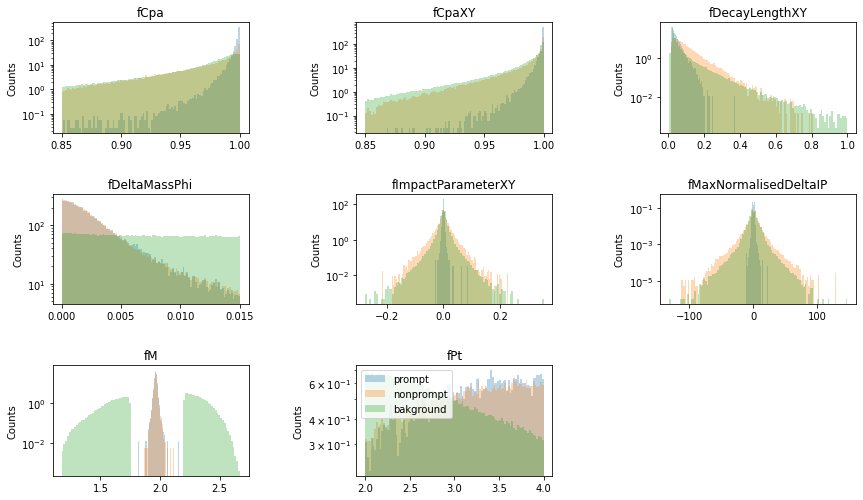

In [51]:
vars_to_draw = ['fCpa', 'fCpaXY', 'fDecayLengthXY', 
                'fDeltaMassPhi', 'fImpactParameterXY',
                'fMaxNormalisedDeltaIP', 'fM', 'fPt'] ##just a selection of all the possible variables
leg_labels = ["prompt", "nonprompt", "bakground"] ## matching the order of the hdl_all

plot_utils.plot_distr(hdl_all, vars_to_draw, bins=100, labels=leg_labels, log=True, density=True, figsize=(12, 7), alpha=0.3, grid=False)
plt.subplots_adjust(left=0.06, bottom=0.06, right=0.99, top=0.96, hspace=0.55, wspace=0.55)
plt.show()

**Q**: Do the distributions look good? 

**Q**: Which features do you expect to have a larger impact on the BDT score? 

**<font color='red'>_Feedback Time_: does everybody's code working?**</font>

A label is assigned to each candidate of the total set: _0_ for prompt Ds, _1_ for non-prompt Ds, and _2_ for background.

It is important to keep the same order in which the samples are considered also for the labels.

The total dataset is split into a _train set_ and a _test set_, used for training and testing the BDT, respectively.

The fraction of the total set used as test set is defined by the _test_size_ parameter of the function [_sklearn.model_selection.train_test_split_](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and is typically around 0.2. 

In [52]:
train_test_data = train_test_generator(hdl_all, [0, 1, 2], test_size=0.2, random_state=42)

Let's split the training set, the test set, and the relative flags. 

In [53]:
trainset = train_test_data[0]
ytrain = train_test_data[1]
testset = train_test_data[2]
ytestset = train_test_data[3]

Similarly, the correlation matrix for the features is plotted with the function _plt\_utils_._plot\_corr_.

It is important cross-check that none of the features is strongly related to the invariant mass to avoid biasing the measurement!

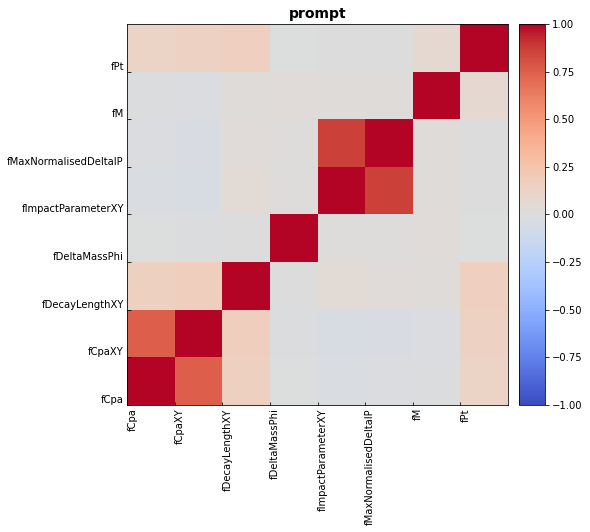

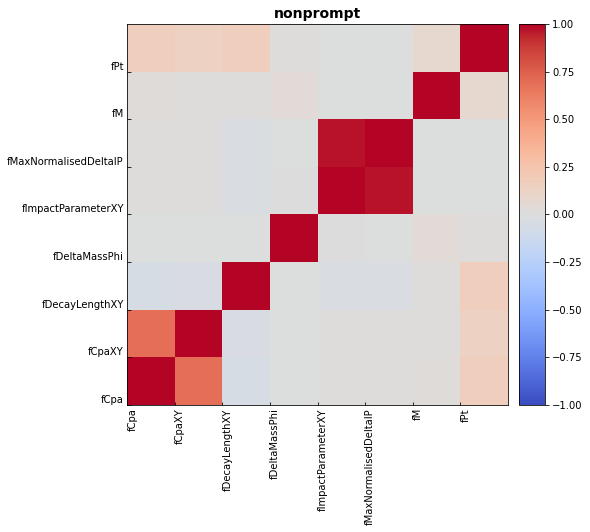

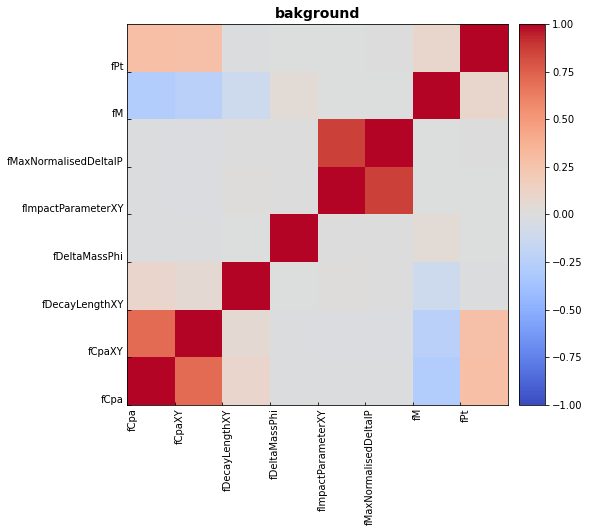

In [54]:
plot_utils.plot_corr(hdl_all, vars_to_draw, leg_labels)
plt.show()

### **The model**

For this tutorial, [_XGBoost_](https://xgboost.readthedocs.io/en/latest/) is used as classification algorithm. XGBoost implementation of the gradient boosted decision trees is designed to be highly efficient, flexible and portable.
_hipe4ml_ can deal with several implementations other than XGBoost models (e.g. LGBM or sklearn models). However, XGBoost models are usually employed in HF analyses.

The _hipe4ml_ package interface with the model through the _ModelHandler_ module. The _ModelHandler_ is used to define the features used in the training process and to set the _hyperparameters_ of the model, such as the number of estimators, the maximum depth of the trees and the learning rate.

Let's initialise the algorithm with the features we want to include in the training. Remember to exclude the mass and the $p_{\mathrm{T}}$ of the candidate!!! 


In [55]:
features_for_train = ['fCpa', 'fCpaXY', 'fDecayLength', 'fDecayLengthXY', 'fDeltaMassPhi', 'fImpactParameterXY', 'fAbsCos3PiK',
                      'fMaxNormalisedDeltaIP'] 

model_params = {'max_depth':5, 'learning_rate':0.029, 'n_estimators':500, 'min_child_weight':2.7, 'subsample':0.90, 'colsample_bytree':0.97, 'n_jobs':1, 'tree_method': 'hist'}

model_clf = xgb.XGBClassifier()
model_hdl = ModelHandler(model_clf, features_for_train, model_params)

A huge number of features would lead to a large time and CPU consumption. For this reason, we decided to limit the number of variables in the training.

### **Optimisation of hyperparameters with Optuna**
The _hyperparameters_ consist of the internal parameters of the BDT algorithm which are not optimised within the training phase. Few of them are listed here below, for a complete description see the [_XGBoost-Doc_](https://xgboost.readthedocs.io/en/stable/parameter.html)
- _n_estimators_: Number of trees in the BDT
- _max_depth_: Maximum depth of a tree
- _eta_: learning rate of the algorithm. It controls the step size of the gradient descent algorithm

The optimisation of the hyperparameters is a key step to obtain the best performance from the algorithm. In _hipe4ml_ the [Optuna](https://github.com/optuna/optuna) package is employed for the optimisation through the method _ModelHandler.optimize\_params\_optuna_.

The difference between Optuna and other packages dedicated to hyperparameters optimisation based on grid search or random search is that Optuna takes into account the past hyperparameter configuration evaluations when choosing the configuration to evaluate next. (More info about Optuna can be found [here](https://arxiv.org/abs/1907.10902)).

A set of hyperparameters should be tested on different samples to avoid overfitting problems. Since the number of events is limited, an approach called _k-flod cross validation_ is used. It has been proved that the cross validation removes the dependence of the model on the data sample. 

In the cross validation procedure, the original sample is divided in _k_ parts called _folds_ (in this case 5 folds are used). For each set of hyperparameters, _n-1_ folds are used for the optimisation and the remaining one as test. This operation is repeated after permuting the folds used for optimisation and for testing and the final result is the mean value of all the permutations.

The _ModelHandler_ automatically updates the hyperparameters after their optimisation.

To spare time, in this tutorial the hyperparameter optimisation and the number of configuration was limited.

The optimised configuration can be saved (have a look at the Addendum!) and loaded afterwards. Let's have a look!

In [56]:
import optuna as op
import pickle

opstudy = pickle.load(open("optuna_study.pkl", "rb")) # load the study

fig = op.visualization.plot_optimization_history(opstudy) # plot the history of the study
fig.show()

fig = op.visualization.plot_param_importances(opstudy) # plot the importance of the hyperparameters
fig.show()

### **Training and testing the model**
The model training is performed with the method _train\_test\_model_ of the _ModelHandler_ module. It requires as argument a list containing:
1. the training set;
2. the true class label for the training set;
3. the test set;
4. the true class label for the test set;
5. the multiclass option.

The multi-class option can be set to _ovo_ (i.e._OneVsOne_) or _ovr_ (i.e._OneVeRest_). In the first configuration, for each possible couple of classes a BDT algorithm is trained considering the first class as signal and the second one as background. In the second configuration, for each class a BDT algorithm is trained considering that class as signal and the others as background. In both cases, the final score associated with a candidate is computes as an average of the different BDT scores.

In [57]:
model_hdl.train_test_model(train_test_data, multi_class_opt="ovo")

# the same result can be obtained by splitting the training and test process with the functions below:
# model_hdl.fit(trainset, ytrain, multi_class_opt="ovo")
# model_hdl.predict(testset, ytestset, multi_class_opt="ovo")

Training xgboost model for classification
Number of detected classes: 3
Training the model: ...


Training the model: Done!
Testing the model: ...
ROC_AUC_score: 0.911998
Testing the model: Done!


**Q:** How do you apply the BDT to the training and test sets?

**Q:** How do you expect the BDT score distributions to be in the training and test sets?

The predictions for the training and the test sets are obtained with the _predict_ method which has two arguments:
- the data you want to apply the model to
- _output_margin_ a boolean indicating if we want the raw BDT output (True) or a probability (False). For this session we use probabilities!

In [58]:
y_pred_train = model_hdl.predict(train_test_data[0], False)
y_pred_test = model_hdl.predict(train_test_data[2], False)

The results of the training process can be observed by plotting the distributions of the BDT scores for the training and the test sets. The output consists of a score related to the probability to belong to each of the classes used for the training. This operation is performed with the method _plot\_utils_._plot\_output\_train\_test_.

The distributions of the model scores obtained from the test set are in good agreement with those obtained from the training set. This is a sign that the model has been trained properly.

A disagreement between the distributions obtained from the training set and the datasets would reflect an overfitting by the classification algorithm: the classifier has learnt some characteristics that are peculiar of the training set, but that are not true for a general sample.

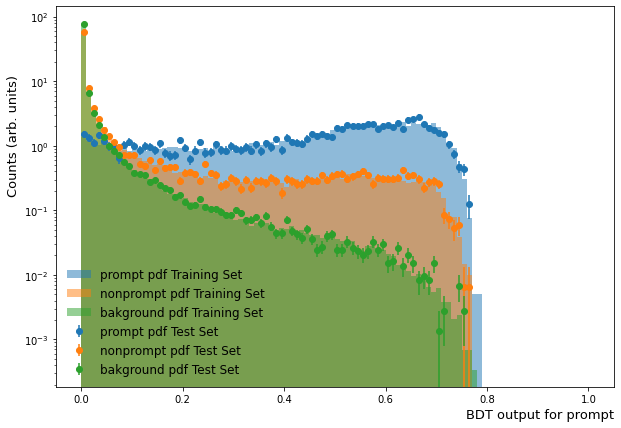

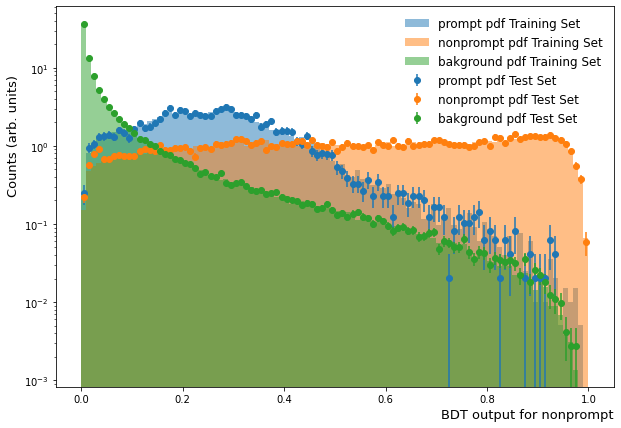

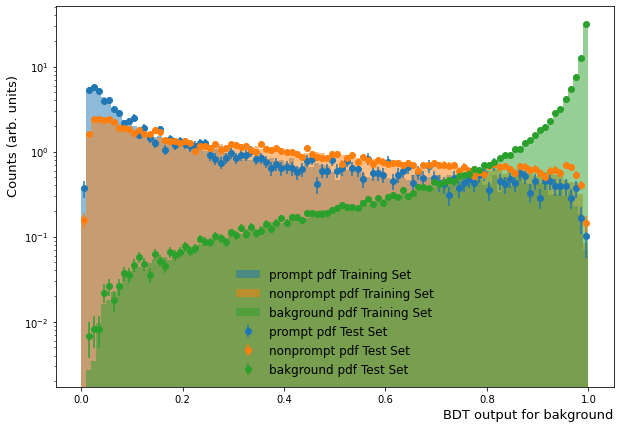

In [59]:
plt.rcParams["figure.figsize"] = (10, 7)

ml_out_fig = plot_utils.plot_output_train_test(model_hdl, train_test_data, 100, 
                                               False, leg_labels, True, density=True)

### **Receiver Operating Curve**
The quality of the algorithm can be also studied with the _ROC curve_. The ROC curve is defined as a function of the _True Positive Rate_ (TPR) against the _False Negative Rate_ (FPR) as a function of a threshold on the BDT score. TPR and FPR are defined as:

$\mathrm{TPR}=\frac{\sum \mathrm{TP}}{\sum \mathrm{TP} + \sum \mathrm{FN}} \hspace{2cm} \mathrm{FPR}=\frac{\sum \mathrm{FP}}{\sum \mathrm{FP} + \sum \mathrm{TN}} $

In the case of multi-classifiaction problems, the ROC curve is not natively defined. Hence, we can either employ the _OneVsOne_ or the _OneVsRest_ approach. In this tutorial, we adopt the _OneVsOne_. Therefore, the TPR and the FPR represent the selection efficiency for the first class, considered as signal, and the rejection
efficiency of the second class, considered as background, for each couple of classes, respectively.

The most common way employed to evaluate the performance of a BDT is to compute the _Area Under the Curve_ ROC, called AUC:
- a perfect classifier will have a ROC AUC equal to 1.0;
- a random classifier will have a ROC AUC equal to 0.5.

A good model classifier is characterised by a large area under the ROC curve (_ROC AUC_).

**Q**: How do you expect the ROC Curve to be?

**Q**: How do you expect the ROC AUC to be?

**Q**: Do you expect any difference between training and test? 


The ROC curve can be plotted with the method _plot\_utils_._plot\_roc\_train\_test_. 

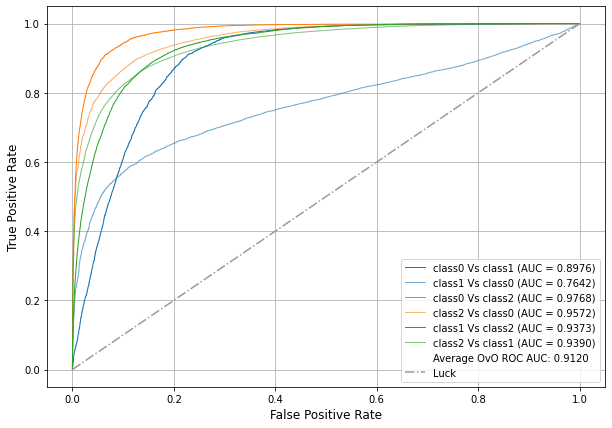

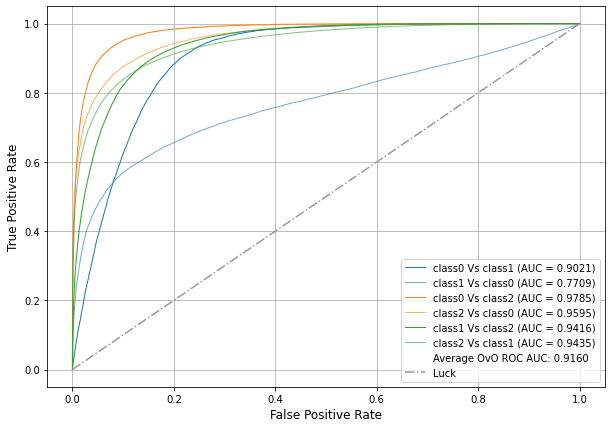

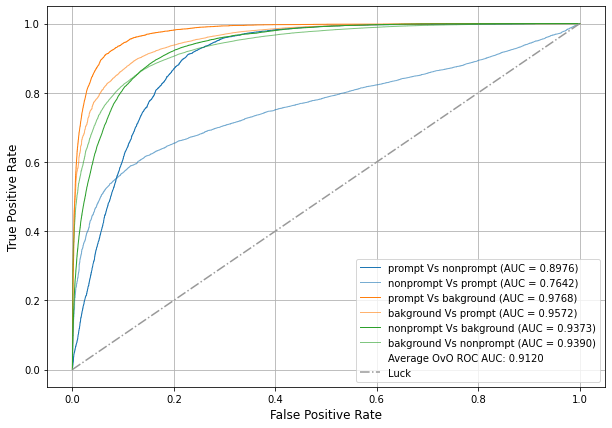

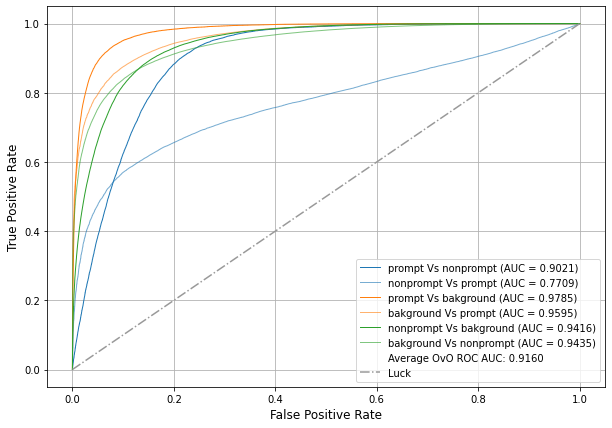

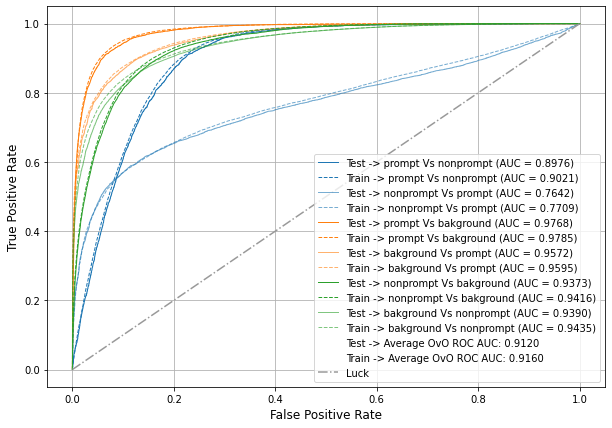

In [60]:
plot_utils.plot_roc(ytestset, y_pred_test, leg_labels, multi_class_opt="ovo")

plot_utils.plot_roc(ytrain, y_pred_train, leg_labels, multi_class_opt="ovo")



roc_train_test_fig = plot_utils.plot_roc_train_test(train_test_data[3], y_pred_test, train_test_data[1], y_pred_train, None, leg_labels, multi_class_opt="ovo")

Evaluating the ROC AUC in training and test a slight difference is found. The higher ROC AUC in training compared to test is a systematic behaviour due to the small presence of overfitting, which indicates a successful training.

### **Feature Importance**

It is crucial to assess which feature is more important for the BDT to assign its score. This step is twofold. On one hand, understanding which features are the most important to the BDT can help us to interpret the outcome of the algorithm. On the other hand, the feature importance can be used as a cross-check to ensure that the algorithm predilection for
a specific feature is matched by the physics of the problem under study. For instance in the case of D mesons, the most effective features are expected to be the ones associated with the decay length.

The feature importance implemented in the [SHAP](https://github.com/slundberg/shap) library is used in this hands-on session. In the context of machine learning, the _Shapley value_ is used to evaluate the contribution of each feature to the model output, and it is calculated by averaging the marginal contributions of each feature to the model output. The marginal contribution of a feature is the difference in the model output when the feature is present or absent. The variables that are more important for the model are those that have a higher marginal contribution, and Shapley values consequently.

**Q**: Which features do you expect to weight more?

**Q**: What values will have these features?



The SHAP feature importance can be plotted with the method _plot\_utils_._plot\_feat\_imp_

/home/spolitan/user_python/lib/python3.8/site-packages/shap/plots/_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



[<Figure size 1296x648 with 2 Axes>,
 <Figure size 1296x648 with 2 Axes>,
 <Figure size 1296x648 with 2 Axes>,
 <Figure size 1296x648 with 1 Axes>]

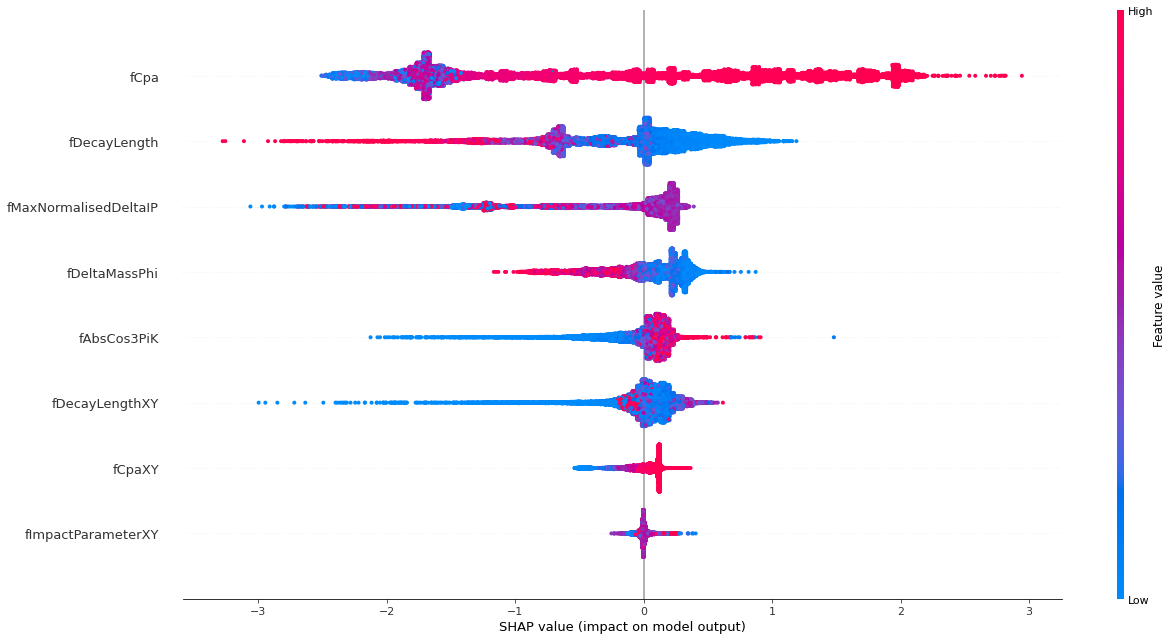

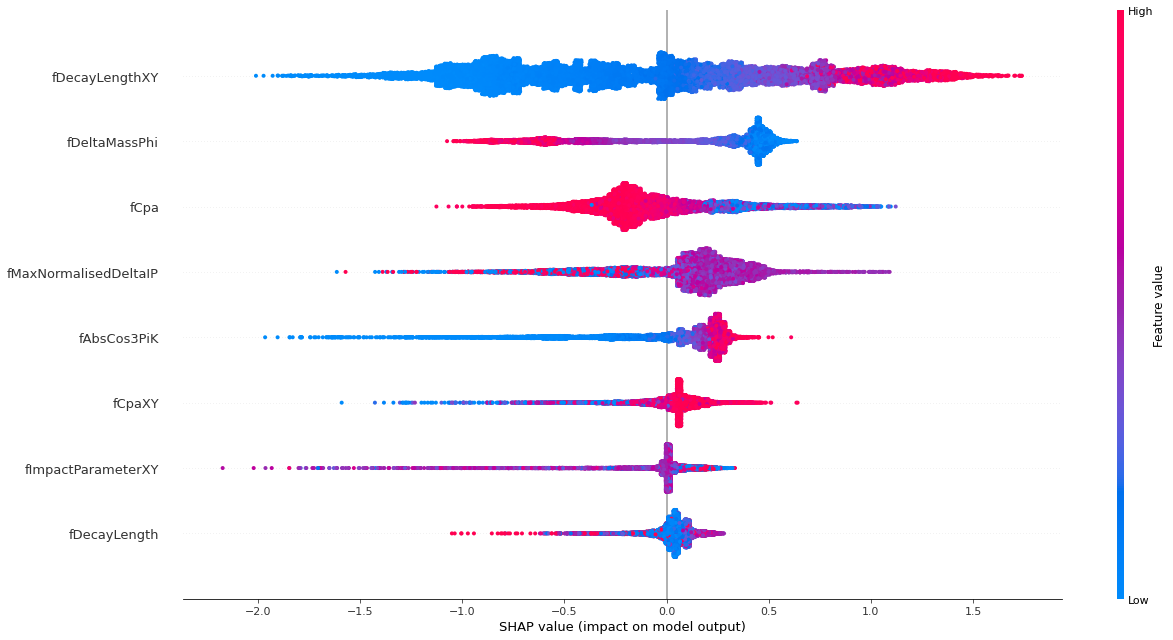

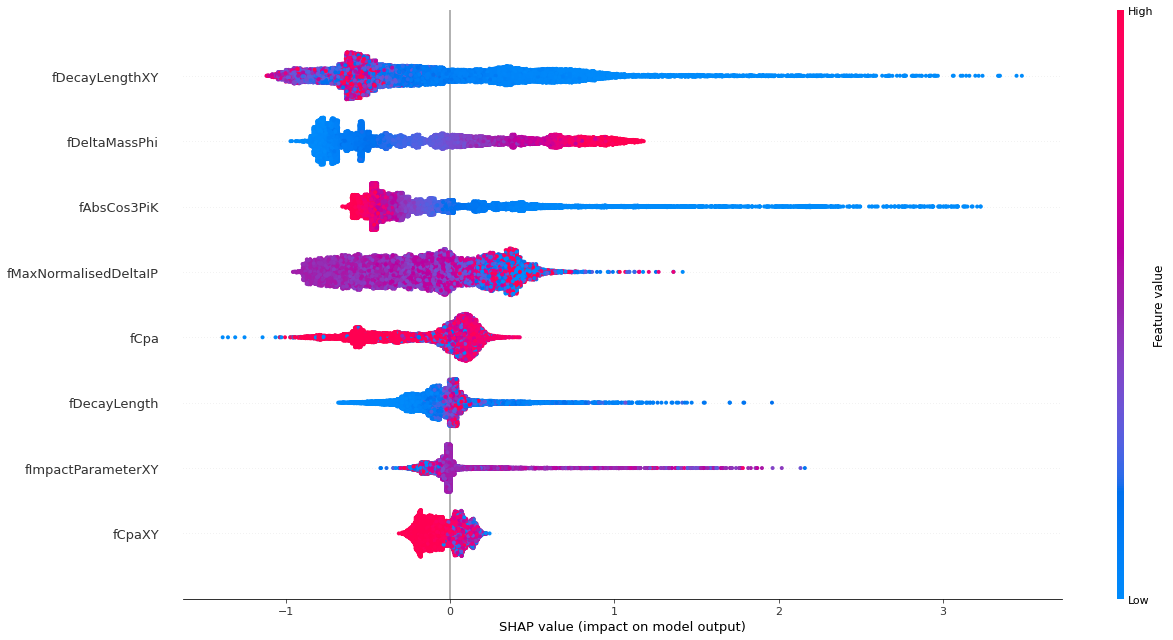

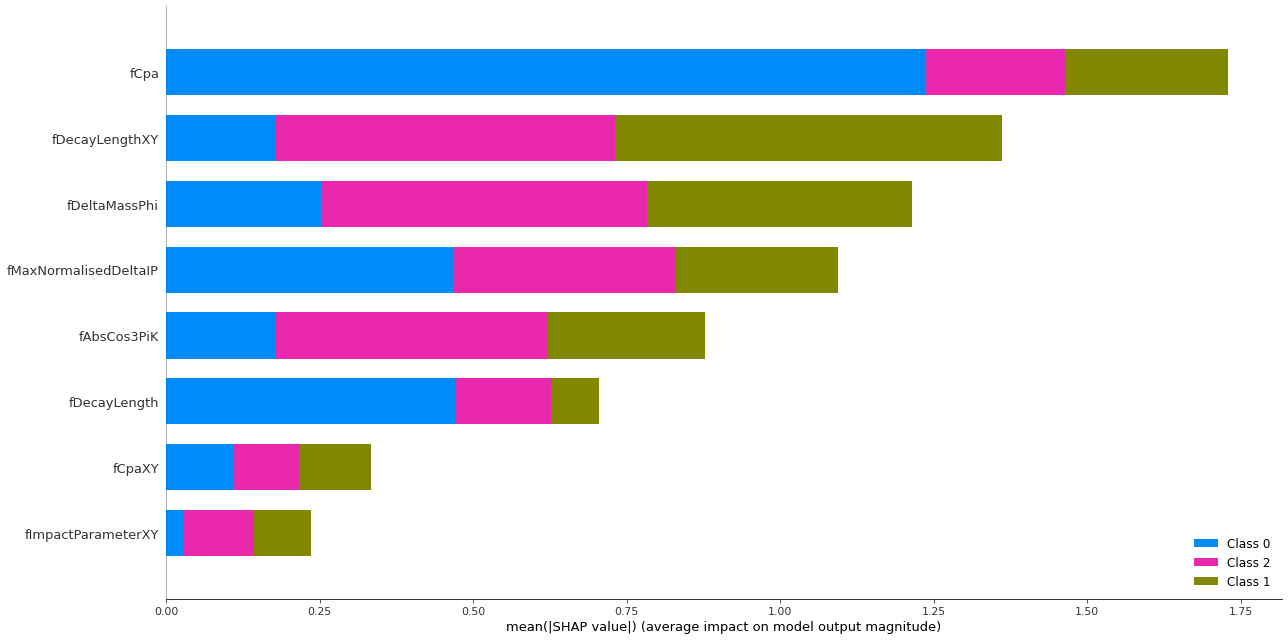

In [61]:
plot_utils.plot_feature_imp(train_test_data[2], train_test_data[3], model_hdl) 

### **Store the trained model**
Once trained and tested, the model can be saved locally.

The model handler from hipe4ml can be saved with the _ModelHandler.dump_model_handler_ function.

The XGBoost model can be saved with the _ModelHandler.dump_original_model_ function.

This will be needed for the Grid application!

In [62]:
model_hdl.dump_model_handler("./ModelHandler_MulticlassDs_pT_2_4.pickle")
model_hdl.dump_original_model("./XGBoostModel_MulticlassDs_pT_2_4.pickle")

### **Convert the model in ONNX format**
To be applied on the Grid, the XGBoost model has to be converted in ONNX format.

This can be done with the _hipe4ml_converter_ package.

In [63]:
from hipe4ml_converter.h4ml_converter import H4MLConverter

model_converter = H4MLConverter(model_hdl) # create the converter object
model_onnx = model_converter.convert_model_onnx(1, len(features_for_train))
model_converter.dump_model_onnx("model_onnx.onnx") # dump the model in ONNX format

File model_onnx.onnx saved


**<font color='red'>_Feedback Time_: the models have been saved for everyone?**</font>


### **Visualise the results**
Let's apply our model to the _hdl_data_appl_ sample!


In [67]:
yPredData = model_hdl.predict(hdl_data_appl, False)
Dsdf = hdl_data_appl.get_data_frame()
Dsdf['prompt_score'] = yPredData[:, 0] # prompt
Dsdf['nonprompt_score'] = yPredData[:, 1] # non-prompt
Dsdf['background_score'] = yPredData[:, 2] # background

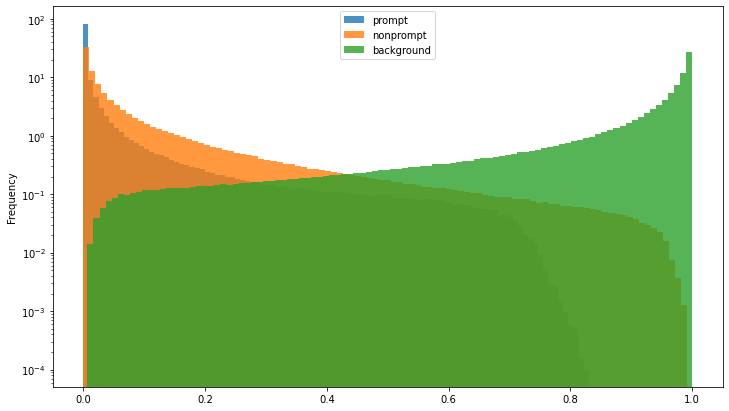

In [68]:
Dsdf['prompt_score'].plot(kind='hist', bins=100, alpha=0.8, log=True, figsize=(12, 7), grid=False, density=True, label='prompt')
Dsdf['nonprompt_score'].plot(kind='hist', bins=100, alpha=0.8, log=True, figsize=(12, 7), grid=False, density=True, label='nonprompt')
Dsdf['background_score'].plot(kind='hist', bins=100, alpha=0.8, log=True, figsize=(12, 7), grid=False, density=True, label='background')
plt.legend()

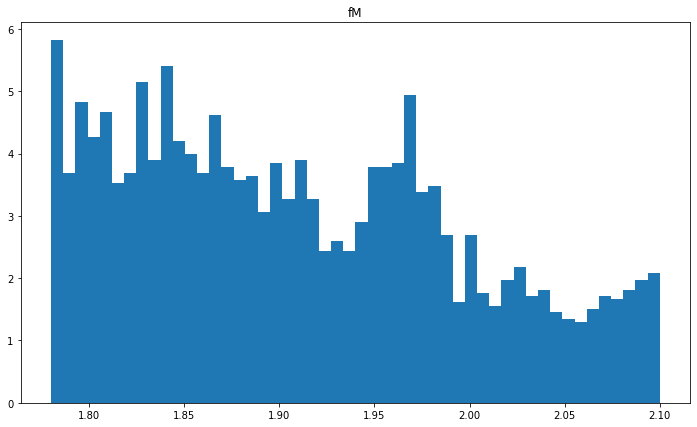

In [69]:
Dsdf_sel = Dsdf.query('prompt_score > 0.5 and background_score < 0.06')
hist = Dsdf_sel.hist(column='fM', bins=50, range=(1.78, 2.1), figsize=(12, 7), grid=False, density=True)

### **Addendum**
You can try to optimise the BDT yourself with Optuna with the following commands.

Remember to set the range in which you want to optimise the hyperparameters, the metric you want to optimise, if you want to maximise or minimise it, and the number of trials you want to try.


In [71]:
#hyper_pars_ranges = {"max_depth": (2, 4), "learning_rate": (0.01, 0.1)}
#model_hdl.optimize_params_optuna(train_test_data, hyper_pars_ranges, cross_val_scoring="roc_auc_ovo",
#                                 n_trials=10, direction="maximize", save_study='optuna_study.pkl')

#fig = op.visualization.plot_contour(opstudy) # plot the correlation between the hyperparameters and the relative performance
#fig.show()

#fig = op.visualization.plot_parallel_coordinate(opstudy) # plot the correlation between the hyperparameters and the relative performance
#fig.show()

### **References**
- [Deep Learning and Its Application to LHC Physics](https://arxiv.org/pdf/1806.11484.pdf)
- [Machine learning at the energy and intensity frontiers of particle physics](https://www.nature.com/articles/s41586-018-0361-2)
- [HEP ML Living Review](https://github.com/iml-wg/HEPML-LivingReview)
- [Inter-Experimental LHC Machine Learning Working Group](https://github.com/iml-wg)

Remember to follow the [ALICE ML meetings](https://indico.cern.ch/category/7570/) for many more inputs and applications of ML techniques!
Contact [Francesco](francesco.mazzaschi@cern.ch) and [Fabio](fabio.catalano@cern.ch) for any questions ;)

# **BEFORE THE COFFEE BREAK!!!** 

Don't forget to download the AO2D file necessary for the next step of the tutorial! You can do this (**on your laptop**) as
```bash
curl -L https://cernbox.cern.ch/s/0gqE44ggCn1y6qJ/download --output AO2D_MC_Ds.root
```
It will take some time to complete.